In [ ]:
# For this skeleton, you need to install torchtext, and optionally spacy. 
# It also uses pretrained word embeddings from glove.6B.100d which is around 850 MB. You can skip using it if you don't have enough 
# memory to work with. But training will be faster if you use it.

In [1]:
from torchtext import data
from torchtext import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [ ]:
#### Section 1: Spacy (optional) ###
# Uncomment this lines if you are using spacy
# import spacy
# nlp = spacy.load('en_core_web_sm')

In [4]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
text_train = pd.read_csv(r"clean\large-clean-train.csv")
text_train.head()
text_train.sentiment.value_counts()

good    28807
bad     15323
ok       9630
Name: sentiment, dtype: int64

In [6]:
text_val = pd.read_csv(r"clean\large-clean-val.csv")
text_val.head()
text_val.sentiment.value_counts()

good    16193
bad      8677
ok       5370
Name: sentiment, dtype: int64

In [9]:
text = pd.concat([text_train, text_val])

In [7]:
#### Section 2: Tokenizer ###
# create a tokenizer function
def tokenizer(text): 
    # return a list of words. You may skip the stop words defined by spacy or nltk lib
    stop_words = set(stopwords.words('english'))
    nltk_tokens = nltk.word_tokenize(text)
    filtered_sentence = [w for w in nltk_tokens if not w in stop_words]
    return filtered_sentence

In [10]:
counts = Counter()
for index, row in text.iterrows():
    counts.update(tokenizer(row['reviewText']))
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 33956
num_words after: 17440


In [11]:
def tokenizer(text): 
    # return a list of words. You may skip the stop words defined by spacy or nltk lib
    stop_words = set(stopwords.words('english'))
    nltk_tokens = nltk.word_tokenize(text)
    filtered_sentence = [w for w in nltk_tokens if not w in stop_words and w in counts]
    return filtered_sentence

In [12]:
TEXT = data.Field(tokenize = tokenizer, lower=True, include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)
fields = {'reviewText': ('t', TEXT), 'sentiment': ('l', LABEL)}

C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [35]:
# stratified sampling
label = text.sentiment
train_data, valid_data, y_train, y_val = train_test_split(text, label, test_size=0.33, stratify=label, random_state=42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
train_data.to_csv(r'clean\large-stratified-train.csv', index=False)
valid_data.to_csv(r'clean\large-stratified-val.csv', index=False)
train_data.head()
# train_data.sentiment.value_counts()/len(train_data)
# valid_data.sentiment.value_counts()/len(valid_data)

,overall,reviewText,summary,vote,category,sentiment
0,3,"For a ""one size"" this fits reeeaally tight aro...",Did the job for Halloween,0,fashion,ok
1,2,The belt is fine but the color is way off! Th...,Color is not as shown.,0,fashion,bad
2,5,"Well built, solid product which is an attracti...",Solid product,0,beauty,good
3,5,love this body wash! scent is sophisticated a...,love this body wash,0,beauty,good
4,1,No good for my washer. I will be returning pro...,One Star,0,appliance,bad


In [13]:
#### Section 3: Datasets ###
# while you experiment, use the small datasets. Final training and evaluation needs to be done with large datasets. 
suffix = 'large-'
# suffix = 'large-'
dataFolder = 'clean' # keep all your data files in a single folder

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = dataFolder, 
                                        train = suffix + 'stratified-train.csv', # json file
                                        validation = suffix + 'stratified-val.csv',# json file
                                        test = suffix + 'stratified-val.csv',# json file
                                        format = 'csv', # json file
                                        fields = fields
)

C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torchtext\data\example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [14]:
#### Section 4: Vocabulary ###

# You can use GloVe vocabulary to train your model faster towards convergence or build up your own embeddings. 
# If you are not using the GloVe embeddings, you will need to comment out the embedding weight transfer to model in 
# Section 9

MAX_VOCAB_SIZE = 25000

#Local vocabulary
# TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
# LABEL.build_vocab(train_data)

#GloVe vocabulary
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

# Check if it worked
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(valid_data)}')
print(vars(train_data[0]))

Number of training examples: 56280
Number of testing examples: 27720
{'t': ['for', '``', 'one', 'size', "''", 'fits', 'reeeaally', 'tight', 'around', 'thigh', '.', 'but', 'maybe', 'i', "'m", 'fat', ',', 'oh', 'well', '!'], 'l': 'ok'}


In [15]:
print(LABEL.vocab.stoi)

defaultdict(None, {'good': 0, 'bad': 1, 'ok': 2})


In [16]:
#### Section 5: Iterators ###
# Iterators organizes datasets into batches and feeds them into the model. In this skeletion, we use packed padded sequence
# to make sure that all the input data points are of the same size and they do not incur unnecessary computation. Read more 
# about packed padded sequence here: https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
# For that, we need to sort the samples in each batch in decreasing order of number of words.


BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort = False, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.t),
    device = device)

C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [17]:
#### Section 6: Vanilla RNN ###

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.dropout = nn.Dropout(p=dropout)
        
        # Add your network's trainable layers here.
        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectional)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
       
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        text = text.transpose(0, 1)
        
        embedded = self.dropout(self.embedding(text))
        embedded = embedded.transpose(0, 1)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence. Clamping the lengths to avoid errors in some bugs
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.clamp(min=1, max=50))
        
        # now packed_embedded is the input to your model. You can do whatever you want to do from this point
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(BATCH_SIZE)
        
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(packed_embedded, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
#         out = unpacked.contiguous().view(-1, self.hidden_dim)
        out=unpacked[:, -1, :]
        out = self.fc(out)
        
        return out
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [18]:
#### Section 7: Advanced Model ###

class AdvancedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Add your network's trainable layers here.
        # Define some parameters
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Define layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        text = text.transpose(0, 1)
        embedded = self.dropout(self.embedding(text))
        embedded = embedded.transpose(0, 1)
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence. Clambing the lengths to avoid errors in some bugs
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.clamp(min=1, max=50))
        
        # now packed_embedded is the input to your model. You can do whatever you want to do from this point
        # Initializing hidden state for first input using method defined below
#         hidden = self.init_hidden(BATCH_SIZE)
        lstm_out, hidden = self.lstm(packed_embedded)
        
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        lstm_out=unpacked[:, -1, :]
        
        out = self.fc(lstm_out)
        out = self.sigmoid(out)

        return out
    
#     def init_hidden(self, batch_size):
#         weight = next(self.parameters()).data
#         hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
#                       weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
#         return hidden

In [19]:
#### Section 8: Create your models ###
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 400
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [20]:
# Instantiate the model with hyperparameters
model = VanillaRNN(vocab_size=INPUT_DIM, embedding_dim=EMBEDDING_DIM, output_dim=OUTPUT_DIM, hidden_dim=HIDDEN_DIM, 
                   n_layers=N_LAYERS, dropout=DROPOUT, bidirectional=False, pad_idx=PAD_IDX)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

VanillaRNN(
  (embedding): Embedding(13107, 100, padding_idx=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): RNN(100, 400, batch_first=True)
  (fc): Linear(in_features=400, out_features=3, bias=True)
)

In [31]:
# Instantiate the advanced model with hyperparameters
model_adv = AdvancedModel(vocab_size=INPUT_DIM, embedding_dim=EMBEDDING_DIM, output_dim=OUTPUT_DIM, hidden_dim=HIDDEN_DIM, 
                   n_layers=N_LAYERS, dropout=DROPOUT, bidirectional=False, pad_idx=PAD_IDX)
# We'll also set the advanced model to the device that we defined earlier (default is CPU)
model_adv.to(device)

AdvancedModel(
  (embedding): Embedding(13107, 100, padding_idx=1)
  (lstm): LSTM(100, 400, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [32]:
#### Section 9: Transfer pretrained weights for word embeddings from GloVe ###
# Must be commented out if you are not using GloVe embeddings

'''
use model for VanillaRNN
use model_adv for LSTM
'''

pretrained_embeddings = TEXT.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeddings)
model_adv.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.5166, -0.3016, -0.1821,  ...,  0.2555, -0.0826,  0.2384],
        [-0.1842, -0.2294,  0.0790,  ...,  0.3590,  0.0523,  0.1714],
        [-0.8903, -0.6907,  0.7263,  ...,  0.0038,  0.0557, -1.6627]])

In [33]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

'''
use model for VanillaRNN
use model_adv for LSTM
'''

model_adv.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_adv.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
# model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
# model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [34]:
#### Section 10: Optimizer and Loss 
# Feel free to use any you want

'''
use model for VanillaRNN
use model_adv for LSTM
'''

lr=0.001
optimizer = optim.Adam(model_adv.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr)

model_adv = model_adv.to(device)
# model = model.to(device)


# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [25]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    predictedLabel = torch.argmax(torch.exp(preds), dim=1)
    correct = (predictedLabel == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [26]:
#### Section 11: Training process
# Feel free to change
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.t
        
        if text_lengths.shape[0]==BATCH_SIZE:
        
            predictions = model(text, text_lengths).squeeze(1)
        
            loss = criterion(predictions, batch.l)
        
            acc = accuracy(predictions, batch.l)
        
            loss.backward()
#             for name, parms in model.named_parameters(): 
#                 print('-->name:', name, '-->grad_requirs:',parms.requires_grad, ' -->grad_value:',parms.grad)
        
            optimizer.step()
        
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
#### Section 11: Evaluation process
# Feel free to change
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.t
            if text_lengths.shape[0]==BATCH_SIZE:
            
                predictions = model(text, text_lengths).squeeze(1)
            
                loss = criterion(predictions, batch.l)
            
                acc = accuracy(predictions, batch.l)

                epoch_loss += loss.item()
                epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [80]:
#### Section 12: Train

# You need to change this name for each model.
modelOutputName = 'vanilla-rnn.pt'

N_EPOCHS = 30

best_valid_loss = float('inf')

epochs = []
train_accuracy = []
valid_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    epochs.append(epoch)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), modelOutputName)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print('best validation loss: ', best_valid_loss)

Epoch: 01 | Epoch Time: 2m 18s
	Train Loss: 1.001 | Train Acc: 52.57%
	 Val. Loss: 1.080 |  Val. Acc: 46.97%
best validation loss:  1.0797648636578001
Epoch: 02 | Epoch Time: 2m 59s
	Train Loss: 0.862 | Train Acc: 62.08%
	 Val. Loss: 1.003 |  Val. Acc: 65.17%
best validation loss:  1.0029821105288483
Epoch: 03 | Epoch Time: 3m 11s
	Train Loss: 0.828 | Train Acc: 63.97%
	 Val. Loss: 1.157 |  Val. Acc: 58.72%
best validation loss:  1.0029821105288483
Epoch: 04 | Epoch Time: 3m 16s
	Train Loss: 0.763 | Train Acc: 67.17%
	 Val. Loss: 0.700 |  Val. Acc: 70.07%
best validation loss:  0.6998336655396776
Epoch: 05 | Epoch Time: 3m 21s
	Train Loss: 0.695 | Train Acc: 69.95%
	 Val. Loss: 0.677 |  Val. Acc: 70.61%
best validation loss:  0.6774654293156606
Epoch: 06 | Epoch Time: 3m 20s
	Train Loss: 0.676 | Train Acc: 70.49%
	 Val. Loss: 0.694 |  Val. Acc: 70.19%
best validation loss:  0.6774654293156606
Epoch: 07 | Epoch Time: 3m 18s
	Train Loss: 0.667 | Train Acc: 70.88%
	 Val. Loss: 0.706 |  Va

In [52]:
#### Section 12: Train

# You need to change this name for each model.
modelOutputName = 'LSTM-rnn.pt'

N_EPOCHS = 30

best_valid_loss = float('inf')

epochs_LSTM = []
train_accuracy_LSTM = []
valid_accuracy_LSTM = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_adv, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_adv, valid_iterator, criterion)
    
    epochs_LSTM.append(epoch)
    train_accuracy_LSTM.append(train_acc)
    valid_accuracy_LSTM.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_adv.state_dict(), modelOutputName)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print('best validation loss: ', best_valid_loss)

C:\Users\Liwei Liu\Anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Epoch Time: 5m 51s
	Train Loss: 0.921 | Train Acc: 62.61%
	 Val. Loss: 0.837 |  Val. Acc: 70.52%
best validation loss:  0.8371590868764989
Epoch: 02 | Epoch Time: 6m 28s
	Train Loss: 0.824 | Train Acc: 71.51%
	 Val. Loss: 0.801 |  Val. Acc: 73.63%
best validation loss:  0.8009010730144679
Epoch: 03 | Epoch Time: 6m 42s
	Train Loss: 0.798 | Train Acc: 73.90%
	 Val. Loss: 0.789 |  Val. Acc: 74.81%
best validation loss:  0.7887236277835602
Epoch: 04 | Epoch Time: 6m 49s
	Train Loss: 0.783 | Train Acc: 75.42%
	 Val. Loss: 0.787 |  Val. Acc: 74.82%
best validation loss:  0.7866121731737206
Epoch: 05 | Epoch Time: 6m 51s
	Train Loss: 0.775 | Train Acc: 76.19%
	 Val. Loss: 0.783 |  Val. Acc: 75.16%
best validation loss:  0.7831171196248582
Epoch: 06 | Epoch Time: 6m 52s
	Train Loss: 0.767 | Train Acc: 77.15%
	 Val. Loss: 0.780 |  Val. Acc: 75.54%
best validation loss:  0.7804512875106248
Epoch: 07 | Epoch Time: 6m 52s
	Train Loss: 0.758 | Train Acc: 78.09%
	 Val. Loss: 0.780 |  Va

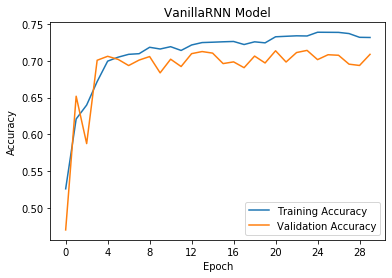

In [81]:
#### Section 13: Plots
# plot VanillaRNN accuracy
ax = plt.figure().gca()
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, valid_accuracy, label='Validation Accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('VanillaRNN Model')
plt.legend()

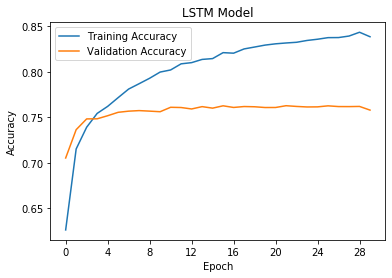

In [53]:
# plot LSTM accuracy
ax = plt.figure().gca()
plt.plot(epochs_LSTM, train_accuracy_LSTM, label='Training Accuracy')
plt.plot(epochs_LSTM, valid_accuracy_LSTM, label='Validation Accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('LSTM Model')
plt.legend()

In [35]:
#### Section 14: Test Code

# 1. Load a saved model
# 2. evaluate against the validation set (you will need to create )

'''
Instructions: skip the stratified sampling, Section 12 training part and after
use model for VanillaRNN
use model_adv for LSTM
'''
model_adv.load_state_dict(torch.load('LSTM-rnn.pt'))
# model.load_state_dict(torch.load('vanilla-rnn.pt'))

test_loss, test_acc = evaluate(model_adv, test_iterator, criterion)
# test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.776 | Test Acc: 76.09%


In [55]:
#### Section 15: Application
# import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

BATCH_SIZE = 1

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    print(model(tensor, length_tensor))
    
    prediction = torch.argmax(torch.exp(model(tensor, length_tensor)), dim=1)
    return LABEL.vocab.itos[prediction.item()]

In [56]:
predict_sentiment(model_adv, "This film is terrible")

tensor([[6.9288e-05, 9.9999e-01, 3.9930e-04]], grad_fn=<SigmoidBackward>)


'bad'

In [57]:
predict_sentiment(model_adv, "This film is great")

tensor([[9.9993e-01, 2.7128e-04, 8.3493e-04]], grad_fn=<SigmoidBackward>)


'good'